## Data sampling and visualization

We provide a sampler which can sample 2D labeled data points in predefined data distribution. In this assignment, we first sample the training and validation data then implement norm regularization and early stopping. To check the effects of each component, we visualize the classification result by plotting the zero-crossing line.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import edf
import copy

# you can change this to generate different data samples
np.random.seed(1234)

class Sampler:
    # hyperparameter for data distribution
    sigma = 0.1 # scale of noisy 2D offset.
    radius = 0.3
    center_1 = [-0.5 * radius, -radius * 0.3]
    center_2 = [0.5 * radius, radius * 0.3]

    def __init__(self, sigma=0.01):
        self.sigma = sigma

    def sample (self, sample_n=10):
        samples_in_uniform_dist = np.random.rand(sample_n, 4) # 4 random variables for each sample (binary label, angle, x, y offset)

        X = np.zeros([sample_n, 2], dtype = np.float32)
        y = np.zeros([sample_n, 1], dtype = np.int32)

        # sample the label
        y[samples_in_uniform_dist[:, 0] > 0.5] = 1

        # sample the angle
        angles = samples_in_uniform_dist[:, 1:2] * np.pi
        cos_thetas = np.cos(angles)
        sin_thetas = np.sin(angles)

        # sample the offset
        offsets = norm.ppf (samples_in_uniform_dist[:,2:4])* self.sigma

        X[:, :1][y == 0] = cos_thetas[y == 0] * self.radius + self.center_1[0]
        X[:, 1:2][y == 0] = sin_thetas[y == 0] * self.radius + self.center_1[1]
        X[:, :1][y == 1] = cos_thetas[y == 1] * self.radius + self.center_2[0]
        X[:, 1:2][y == 1] = -sin_thetas[y == 1] * self.radius + self.center_2[1]

        # add x, y offset
        X += offsets
        y = y[:, 0]

        return X, y


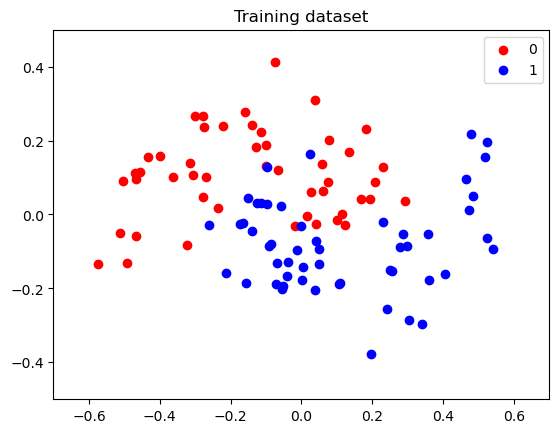

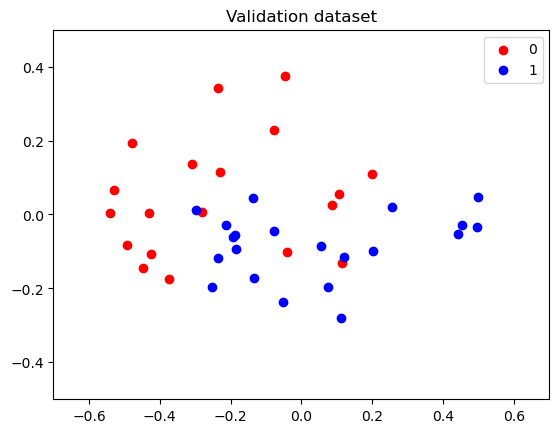

In [2]:
# samplers for train and validation datasets
sampler_train = Sampler(0.1)
sampler_valid = Sampler(0.1)

# sample training and validation datasets
X_train, y_train = sampler_train.sample(100)
X_valid, y_valid = sampler_valid.sample(40)

X = X_train
y = y_train

# plot point clouds
def plot(X0, X1, title_name=''):
    plt.title(title_name)
    plt.scatter(X0[:, 0], X0[:, 1], color='red', label=0)
    plt.scatter(X1[:, 0], X1[:, 1], color='blue', label=1)
    
    plt.xlim([-0.7, 0.7])
    plt.ylim([-0.5, 0.5])
    plt.legend()
    plt.show()
    plt.close()
    
# draw zero-crossing line (black line)
def plot_line(MLP):
    p = np.linspace(-0.5, 0.5, 500)
    x_plot, y_plot = np.meshgrid(p, p)
    X_plot = np.stack((x_plot, y_plot), axis=2).reshape(-1, 2)

    output = MLP.forward(X_plot)
    output_plot = np.round(output.reshape(x_plot.shape[0], x_plot.shape[1]))

    origin = 'lower'
    plt.contour(
        x_plot,
        y_plot,
        output_plot,
        [0.5],
        colors=('k',),
        linewidths=(3,),
        origin=origin
    )

# plot training data and validation data
plot(X_train[y_train == 0], X_train[y_train == 1], title_name='Training dataset')
plot(X_valid[y_valid == 0], X_valid[y_valid == 1], title_name='Validation dataset')

In [3]:
# The function you will need (we implemented this in exercise 1)
class SingleProbToProbVector(edf.CompNode):
    def __init__(self, z):
        edf.CompNodes.append(self)
        self.z = z

    def forward(self):
        self.value = np.repeat(self.z.value, 2, axis=1)
        self.value[:, 1] = 1 - self.value[:, 1]

    def backward(self):
        self.z.addgrad((self.grad[:, 0] - self.grad[:, 1]).reshape(-1, 1))

## Norm Penalty Regularization

We produce the multi-layer perceptron (MLP) class which supports norm penalty regularization. Your task is to complete the implementation of the computational nodes `L1NormPenalty` and `L2NormPenalty`, that you will find futher down in the notebook. In the `MLP` class below, `__init__(...)` is the function which builds the computational graph for training in the EDF framework. `forward(...)` computes the forward pass of the constructed model. `save(...)` stores the current state of the network in the variable `snapshot`, while `load(...)` initializes the network using the stored state. 

**3.2.(a).** To help you understand the implemented `MLP` model, it is recomended that you draw the computational graph of a 2-hidden-layer MLP network including the loss nodes. To simplify the drawing you can group multiple computational nodes in the implementation below, to a single computation node that you draw in your graph e.g. (affine -> sigmoid) can be grouped as a single 'hidden layer' node in your drawing. You can assume that the PenaltyNode is not None e.g. that the regularization nodes are used in the computation graph.

To compute the total loss as a single scalar value, we add new computational nodes: `Add` and `AverageMiniBatch`. We first compute an average of the cross-entropy losses over minibatches then we sum all losses as the total loss: regularization loss for each parameter and the average of the cross-entropy losses over minibatches. In this way, we don't have to modify `edf.py` at all.

In [4]:
class Add(edf.CompNode):
    def __init__(self, x_list):
        edf.CompNodes.append(self)
        self.x_list = x_list

    def forward(self):
        value = np.zeros_like(self.x_list[0].value, self.x_list[0].value.dtype)

        for x in self.x_list:
            value += x.value

        self.value = value

    def backward(self):
        for x in self.x_list:
            x.addgrad(np.ones_like(x.value, x.value.dtype) * self.grad[0])

class AverageMiniBatch(edf.CompNode):
    def __init__(self, x):
        edf.CompNodes.append(self)
        self.x = x

    def forward(self):
        value = np.average(self.x.value)
        self.value = np.resize(value, (1, 1))

    def backward(self):
        self.x.addgrad(np.ones_like(self.x.value, self.x.value.dtype) / self.x.value.size * self.grad[0])

In [5]:
# Multi-layer perceptron class
class MLP:
    def __init__(
        self,
        nInputs, # input dimension
        nOutputs, # output dimension
        nLayers, # number of hidden layers
        nHiddens, # number of neurons in hidden layers
        PenaltyNode=None, # penalty norm term
        alpha=None # regularization weight
    ):
        self.nInputs = nInputs
        self.nOutputs = nOutputs
        self.nLayers = nLayers
        self.nHiddens = nHiddens
        self.PenaltyNode = PenaltyNode
        self.alpha = alpha
        # clean global parameters
        edf.clear_compgraph()
        # initialize lists
        weight_params = []
        loss_nodes = []
        layer_shapes = [nInputs,] + [nHiddens,]*nLayers + [nOutputs,]

        # input and label nodes
        x_node = edf.Input()
        y_node = edf.Input()

        # form the MLP by iterating over the output shapes of the each layer
        h = x_node
        for i in range(1, len(layer_shapes)):
            # create parameters, add them to the parameter list, create a hidden layer
            param = edf.AffineParams(layer_shapes[i - 1], layer_shapes[i])
            weight_params.append(param)
            h = edf.Sigmoid(edf.Affine(param, h))
            if PenaltyNode is not None:
                # for each parameter node, create a regularization node by instatiating the PenaltyClass (one of the L1NormPenalty or L2NormPenalty instances)
                reg_loss_node = PenaltyNode(param.A, alpha)
                loss_nodes.append(reg_loss_node) # add the regularization node (part of loss) to the loss node list
                # we usually dont regularize bias terms
                # reg_loss_node = PenaltyNode(param.b, alpha)
                # loss_nodes.append(reg_loss_node)
        
        # the last h stores the output node
        prob_node = SingleProbToProbVector(h)
        ce_loss_node = edf.CrossEntropyLoss(prob_node, y_node)
        # average cross entropy loss over the minibatch
        ce_loss_avg_node = AverageMiniBatch(ce_loss_node) 
        loss_nodes.append(ce_loss_avg_node)

        # store loss node and output node
        self.prob_node = prob_node
        self.output_node = h
        self.total_loss_node = Add(loss_nodes) # final loss sums over all (scalar) losses
        self.x_node = x_node
        self.y_node = y_node
        self.weight_params = weight_params


    def forward(self, X, y=None):
        if y is None:
            y = np.ones_like(X[:, 0], dtype=np.int32)
        
        # parse input
        self.x_node.value = X
        self.y_node.value = y

        # run forward and get output
        edf.Forward()
        output = self.output_node.value

        return output

    def save(self):
        self.snapshot = copy.deepcopy(self)

    def load(self):
        # load parameters from the recorded instance
        self.weight_params = self.snapshot.weight_params
        
        # clean global parameters
        edf.clear_compgraph()

        # input
        x_node = edf.Input()
        y_node = edf.Input()

        loss_nodes = []
        layer_shapes = [self.nInputs,] + [self.nHiddens,]*self.nLayers + [self.nOutputs,]

        h = x_node
        for i in range(0, len(layer_shapes) - 1):
            param = self.weight_params[i]
            h = edf.Sigmoid(edf.Affine(param, h))
            if self.PenaltyNode is not None:
                reg_loss_node = self.PenaltyNode(param.A, self.alpha)
                loss_nodes.append(reg_loss_node)

        # cross entropy loss
        prob_node = SingleProbToProbVector(h)
        ce_loss_node = edf.CrossEntropyLoss(prob_node, y_node)
        ce_loss_avg_node = AverageMiniBatch(ce_loss_node)
        loss_nodes.append(ce_loss_avg_node)

        # store loss node and output node
        self.prob_node = prob_node
        self.output_node = h
        self.total_loss_node = Add(loss_nodes)
        self.x_node = x_node
        self.y_node = y_node

### Training and visualization of the network trained without norm regularization

We provide the training code like in the previous assignment.

In [6]:
def train(num_steps, x, y, x_node, y_node, prob_node, loss_node):
    x_node.value = x
    y_node.value = y
    
    for iteration in range(1, num_steps + 1):
        edf.Forward()
        mean_err = np.mean(np.not_equal(np.argmax(prob_node.value, axis=1), y_node.value))

        edf.Backward(loss_node)
        edf.UpdateParameters()
        
        if iteration in [100, 200, 500, 1000, 5000] or iteration % 10000 == 0:
            print(f'iter: {iteration}, error: {mean_err:.6f}')

Let's get familiar with the `MLP` class. By passing proper hyperparameters to the constructor, we instantiate the `MLP` instance in the `edf` system. In the following code the `MLP` instance uses no norm penalty regularization. 

In [7]:
# MLP hyperparameters
nInputs = 2
nHiddens = 16
nOutputs = 1 
nLayers= 2
# regularization parameters - we use no regularization for this model
PenaltyNode = None
alpha = 0.

#training hyperparameters
num_steps = 20000
learning_rate = 1.
edf.learning_rate = learning_rate

# create and train the MLP
MLP_no_reg = MLP(nInputs, nOutputs, nLayers, nHiddens, PenaltyNode, alpha)
train(num_steps, X, y, MLP_no_reg.x_node, MLP_no_reg.y_node, MLP_no_reg.prob_node, MLP_no_reg.total_loss_node)


iter: 100, error: 0.280000
iter: 200, error: 0.230000
iter: 500, error: 0.220000
iter: 1000, error: 0.210000
iter: 5000, error: 0.060000
iter: 10000, error: 0.060000
iter: 20000, error: 0.050000


Then we visualize the zero-crossing line with the training dataset and the validation dataset.

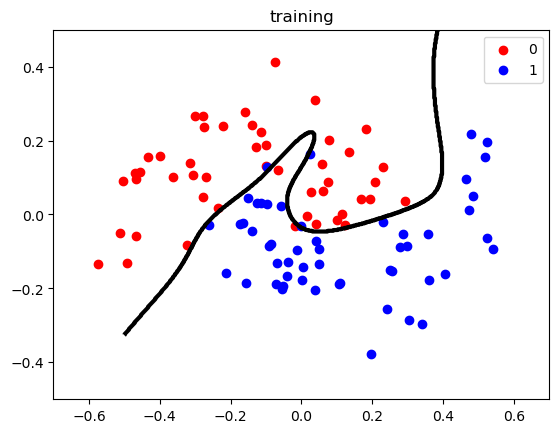

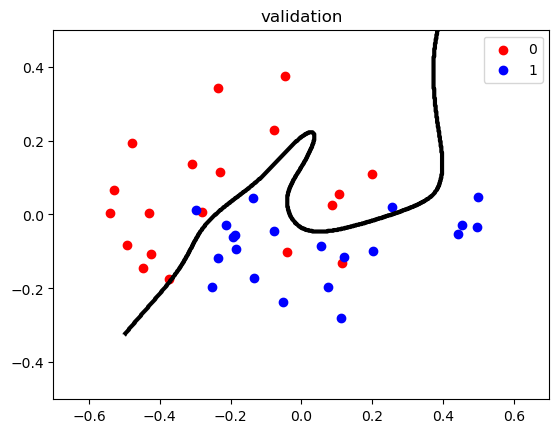

In [8]:
plot_line (MLP_no_reg)
plot(X_train[y_train==0], X_train[y_train==1], title_name='training')

plot_line (MLP_no_reg)
plot(X_valid[y_valid==0], X_valid[y_valid==1], title_name='validation')


### Training and visualization of the network trained with L1 regularization

We can build an MLP with norm penalty terms by passing a norm penalty class as a parameter. Let's create an MLP network with `L1` norm regularization, train the network and see the classification result.

**3.2.(b).** Your task is to implement L1 regularization by completing the `L1NormPenalty` class. In `forward` function, you should compute a scalar value of the L1-norm penalty. In `backward`, you should to compute the gradient of L1-norm penalty.

In [11]:
class L1NormPenalty(edf.CompNode):
    def __init__(self, x, alpha):
        edf.CompNodes.append(self)
        self.x = x
        self.alpha = alpha

    def forward(self):
        value = self.alpha * np.sum(np.abs(self.x.value))
        self.value = np.resize(value, (1, 1))
        
        
    def backward(self):
        dy_dx = np.full((self.x.value.shape[0]*self.x.value.shape[1]), self.alpha)
        self.x.addgrad(dy_dx)

**3.2.(b).** Now we generate the `MLP` object with L1 norm penalty. By setting the hyperparameter of the penalty node class properly, our `MLP` instance constructs the computational graph in the `edf` system automatically.

In [12]:
nInputs = 2
nHiddens = 16
nOutputs = 1
nLayers= 2
PenaltyNode = L1NormPenalty
alpha = 0.001
#training
num_steps = 20000
learning_rate = 1.
edf.learning_rate = learning_rate

MLP_with_L1 = MLP(nInputs, nOutputs, nLayers, nHiddens, PenaltyNode, alpha)
train(num_steps, X, y, MLP_with_L1.x_node, MLP_with_L1.y_node, MLP_with_L1.prob_node, MLP_with_L1.total_loss_node)

iter: 100, error: 0.480000
iter: 200, error: 0.480000
iter: 500, error: 0.460000
iter: 1000, error: 0.450000
iter: 5000, error: 0.440000
iter: 10000, error: 0.440000
iter: 20000, error: 0.430000


Then we visualize the zero-crossing line with the training dataset and the validation dataset.

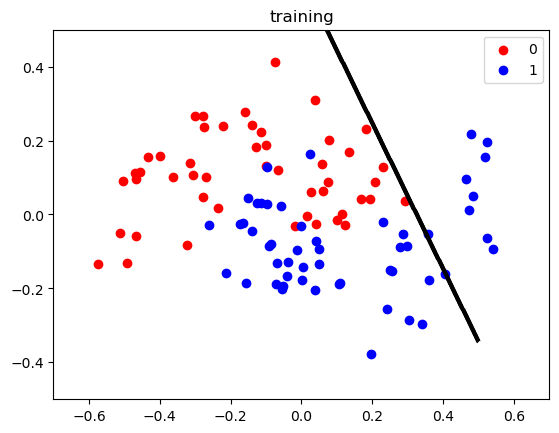

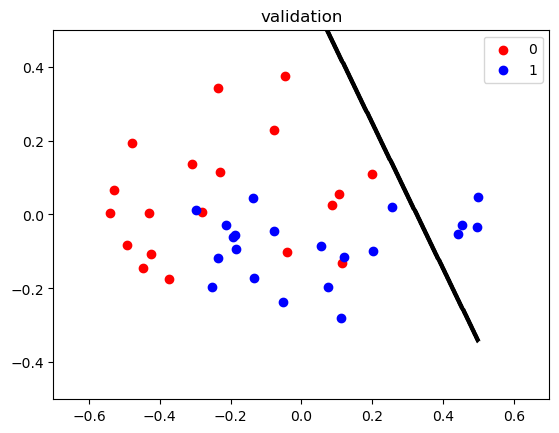

In [13]:
plot_line (MLP_with_L1)
plot(X_train[y_train==0], X_train[y_train==1], title_name='training')

plot_line (MLP_with_L1)
plot(X_valid[y_valid==0], X_valid[y_valid==1], title_name='validation')


### Training and visualization of the network trained with L2 regularization

**3.2.(c).** Your task is to implement L2 regularization by completing the `L2NormPenalty` class. In `forward` function, you should compute a scalar value of the L2 norm penalty. In `backward`, you should compute the gradient of L2 norm penalty.

In [14]:
class L2NormPenalty(edf.CompNode):
    def __init__(self, x, alpha):
        edf.CompNodes.append(self)
        self.x = x
        self.alpha = alpha

    def forward(self):
        value = self.alpha * np.sum(np.power(self.x.value, 2))
        self.value = np.resize(value, (1, 1))

    def backward(self):
        dy_dx = (self.alpha * self.x.value).reshape(((self.x.value.shape[0]*self.x.value.shape[1])))
        self.x.addgrad(dy_dx)
        

**3.2.(c).** Like the previous, we generate the `MLP` object with L2 norm penalty.

In [16]:
nInputs = 2
nHiddens = 16
nOutputs = 1 
nLayers= 2
PenaltyNode = L2NormPenalty
alpha = 0.001
#training
num_steps = 20000
learning_rate = 1.
edf.learning_rate = learning_rate

MLP_with_L2 = MLP(nInputs, nOutputs, nLayers, nHiddens, PenaltyNode, alpha)
train(num_steps, X, y, MLP_with_L2.x_node, MLP_with_L2.y_node, MLP_with_L2.prob_node, MLP_with_L2.total_loss_node)

iter: 100, error: 0.250000
iter: 200, error: 0.240000
iter: 500, error: 0.220000
iter: 1000, error: 0.210000
iter: 5000, error: 0.210000
iter: 10000, error: 0.050000
iter: 20000, error: 0.030000


Then we visualize the zero-crossing line with the training dataset and the validation dataset.

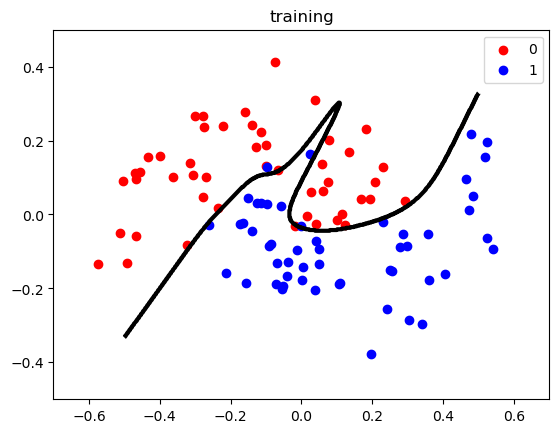

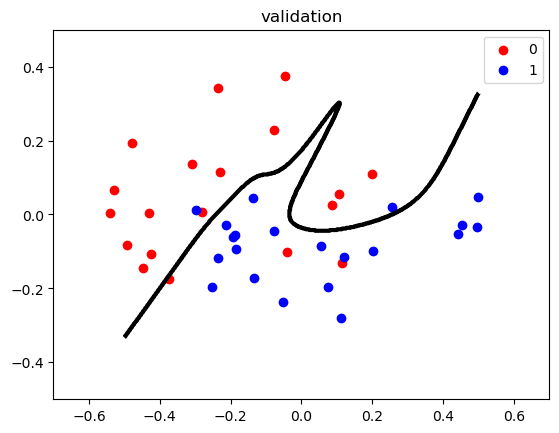

In [17]:
plot_line (MLP_with_L2)
plot(X_train[y_train==0], X_train[y_train==1], title_name='training')

plot_line (MLP_with_L2)
plot(X_valid[y_valid==0], X_valid[y_valid==1], title_name='validation')

## Early stopping

**3.2.(d).** Implement early stopping. By using `mlp.save()`, you can record the current `MLP` state. Your task is to store the model (`mlp.save()`) when current validation error (evaluated every `validation_steps` training iterations) becomes lower than the minimum validation error achieved up to that point in training. If validation error doesn't decrease below the minimum for a certain number of training iterations (`max_passed_steps`), you should end the training.

In [22]:
def train_early_stopping(num_steps, x_train, y_train, x_valid, y_valid, x_node, y_node, prob_node, loss_node, mlp, validation_steps=100, max_passed_steps=5000):
    assert max_passed_steps % validation_steps == 0, 'max_passed_steps must be a multiple of validation_steps'
    # TODO: initialize variables necessary for early stopping implementation
    
    min_val_error = 10e10
    steps_passed_no_decrease = 0
    
    for iteration in range(1, num_steps + 1):
        x_node.value = x_train
        y_node.value = y_train
        
        edf.Forward()
        current_train_err = np.mean(np.not_equal(np.argmax(prob_node.value, axis=1), y_node.value))
        edf.Backward(loss_node)
        edf.UpdateParameters()
        # print(loss_node.value.mean())

        if iteration % validation_steps == 0:
            x_node.value = x_valid
            y_node.value = y_valid

            edf.Forward()
            current_val_loss = np.sum(np.not_equal(np.argmax(prob_node.value, axis=1), y_node.value))

            print(f'iter: {iteration}, train error: {current_train_err:.6f} validation error: {current_val_loss:6f}', end='')
            # TODO: 
            # when current validation error is minimum over all iterations so far, store the current mlp state
            # stop the training if validation loss doesn't decrease for max_passed_steps training steps
            
            if current_val_loss < min_val_error:
                min_val_error = current_val_loss
                print("\nsaving mlp state..")
                mlp.save()
            else:
                steps_passed_no_decrease += 1
                if steps_passed_no_decrease == max_passed_steps:
                    print(f"Training reached {max_passed_steps} without val error decreasing, stopping..")
                    break

            print('')
        

To test how our early stopping works, we build an MLP without any norm penalty. We then train the network using the implemented early stopping training.

In [23]:
nInputs = 2
nHiddens = 16
nOutputs = 1 
nLayers= 2
# norm penalty
PenaltyNode = None
alpha = 0.
# training
num_steps = 20000
learning_rate = 1.
edf.learning_rate = learning_rate
validation_steps = 100
max_passed_steps = 5000

MLP_no_reg = MLP(nInputs, nOutputs, nLayers, nHiddens, PenaltyNode, alpha)
train_early_stopping(num_steps, X_train, y_train, X_valid, y_valid, MLP_no_reg.x_node, MLP_no_reg.y_node, MLP_no_reg.prob_node, MLP_no_reg.total_loss_node, MLP_no_reg, validation_steps, max_passed_steps)


iter: 100, train error: 0.280000 validation error: 12.000000
saving mlp state..

iter: 200, train error: 0.230000 validation error: 10.000000
saving mlp state..

iter: 300, train error: 0.180000 validation error: 10.000000
iter: 400, train error: 0.200000 validation error: 9.000000
saving mlp state..

iter: 500, train error: 0.200000 validation error: 9.000000
iter: 600, train error: 0.200000 validation error: 8.000000
saving mlp state..

iter: 700, train error: 0.210000 validation error: 8.000000
iter: 800, train error: 0.200000 validation error: 8.000000
iter: 900, train error: 0.200000 validation error: 8.000000
iter: 1000, train error: 0.200000 validation error: 8.000000
iter: 1100, train error: 0.200000 validation error: 8.000000
iter: 1200, train error: 0.210000 validation error: 9.000000
iter: 1300, train error: 0.220000 validation error: 9.000000
iter: 1400, train error: 0.200000 validation error: 8.000000
iter: 1500, train error: 0.200000 validation error: 8.000000
iter: 1600,

Then we visualize the zero-crossing line with the training dataset and the validation dataset. `MLP.load()` loads the recorded parameters and constructs the MLP network in the `edf` system.

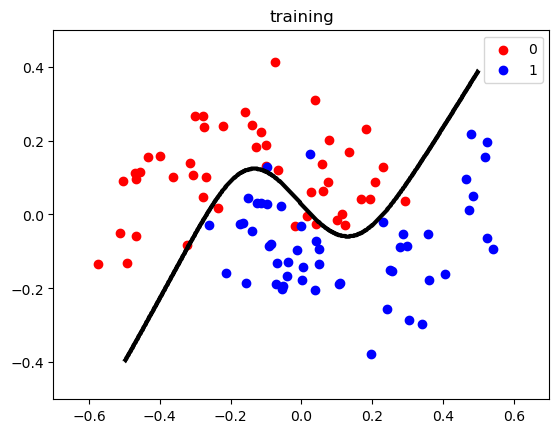

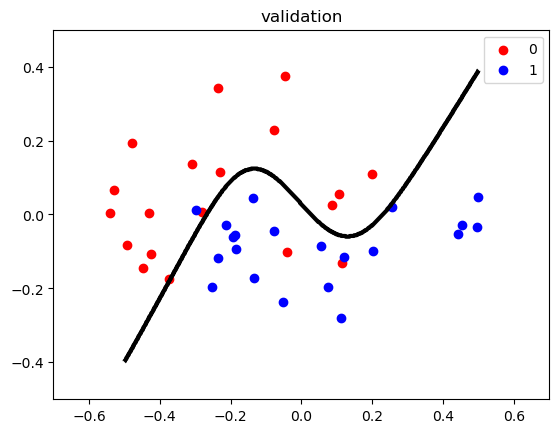

In [24]:
MLP_no_reg.load()

plot_line (MLP_no_reg)
plot(X_train[y_train==0], X_train[y_train==1], title_name='training')

plot_line (MLP_no_reg)
plot(X_valid[y_valid==0], X_valid[y_valid==1], title_name='validation')
